## 개요

In [1]:
"""
KNN 학습/평가 (train-test: random-split 80:20)


설계 개요

- 데이터셋에 음악 파일이 전처리되어 csv 파일로 존재 -> 이 중 그나마 데이터의 개수가 많은 features_3_sec.csv 파일 사용
- test-set이 따로 존재하지 않기에 features_3_sec.csv 파일에서 각 장르별 20곡을 random으로 추출하여 test-set 파일로 재생성생
- leakage 발생을 막기 위해 GroupShuffleSplit 사용
- 추후에 training-set을 음성 파일 자체를 읽는 방식을 사용하거나 test-set이 음성 파일로 들어오는 경우를 생각해볼 예정
- (현재까지는 이미 전처리 된 training-set과 test-set 사용 예정)

- Feature 선택: 음악 장르 분류에 효과적인 피처만 선별
  1) MFCC(1~13)의 mean/var: 음색(템브르)을 대표 — 악기/보컬/음색 차이를 잘 반영
  2) Spectral 특징(centroid, bandwidth, rolloff): 고주파 비중·대역폭·상위 주파수 경계 — 장르의 '밝기/거칠기'와 관련
  3) Zero Crossing Rate: 파형 부호 변화 빈도 — 리듬/고주파 성분이 강한 음악에서 큼
  4) (있다면) Chroma/Harmony mean/var: 화음/조성 정보를 보완

- 학습 로직:
  * Train CSV(0~79번 곡의 세그먼트)에서 위 피처만 X, label을 y로 사용
  * StandardScaler로 정규화 (KNN은 거리기반이라 스케일 민감)
  * KNN(k=5, weights='distance') 학습

- 평가 로직:
  * Test CSV(80~99번 곡의 세그먼트)를 같은 전처리로 예측 → segment 단위 예측
  * filename에서 (장르.곡번호)를 추출해 곡 단위로 모아 다수결(majority vote) → 1곡=1예측
  * 장르당 20곡, 총 200곡 기준으로 성능 출력 (총 몇 곡 맞췄는지 + 장르별 정확도)


추가 feature 관련 내용
- model training의 csv 파일명 변경으로 원하는 csv 파일 사용
- feature engineering의 candidates 부분 주석처리하면 기존 csv 파일도 실행 가능

"""

"\nKNN 학습/평가 (train: features_3_sec_train_0_79.csv, test: features_3_sec_test_80_99.csv)\n\n\n설계 개요\n\n- 데이터셋에 음악 파일이 전처리되어 csv 파일로 존재 -> 이 중 그나마 데이터의 개수가 많은 features_3_sec.csv 파일 사용\n- test-set이 따로 존재하지 않기에 features_3_sec.csv 파일에서 각 장르별 마지막 20곡을 추출하여 test-set 파일로 재생성\n- 추후에 training-set을 음성 파일 자체를 읽는 방식을 사용하거나 test-set이 음성 파일로 들어오는 경우를 생각해볼 예정\n- (현재까지는 이미 전처리 된 training-set과 test-set 사용 예정)\n\n- Feature 선택: 음악 장르 분류에 효과적인 피처만 선별\n  1) MFCC(1~13)의 mean/var: 음색(템브르)을 대표 — 악기/보컬/음색 차이를 잘 반영\n  2) Spectral 특징(centroid, bandwidth, rolloff): 고주파 비중·대역폭·상위 주파수 경계 — 장르의 '밝기/거칠기'와 관련\n  3) Zero Crossing Rate: 파형 부호 변화 빈도 — 리듬/고주파 성분이 강한 음악에서 큼\n  4) (있다면) Chroma/Harmony mean/var: 화음/조성 정보를 보완\n\n- 학습 로직:\n  * Train CSV(0~79번 곡의 세그먼트)에서 위 피처만 X, label을 y로 사용\n  * StandardScaler로 정규화 (KNN은 거리기반이라 스케일 민감)\n  * KNN(k=5, weights='distance') 학습\n\n- 평가 로직:\n  * Test CSV(80~99번 곡의 세그먼트)를 같은 전처리로 예측 → segment 단위 예측\n  * filename에서 (장르.곡번호)를 추출해 곡 단위로 모아 다수결(majority vote) → 1곡=1예측\n  * 장르당 20곡, 총 200

## Importing

In [2]:
import os
import re
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from tqdm import tqdm

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

## EDA


In [3]:
data = pd.read_csv('features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.0645,2002.449060,85882.76132,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.0.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.0736,2039.036516,213843.75550,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.0.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.6434,1747.702312,76254.19226,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.0.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.9424,1596.412872,166441.49480,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.0.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.9393,1748.172116,88445.20904,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
# see features
print(data.columns)

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

### boxplot of features

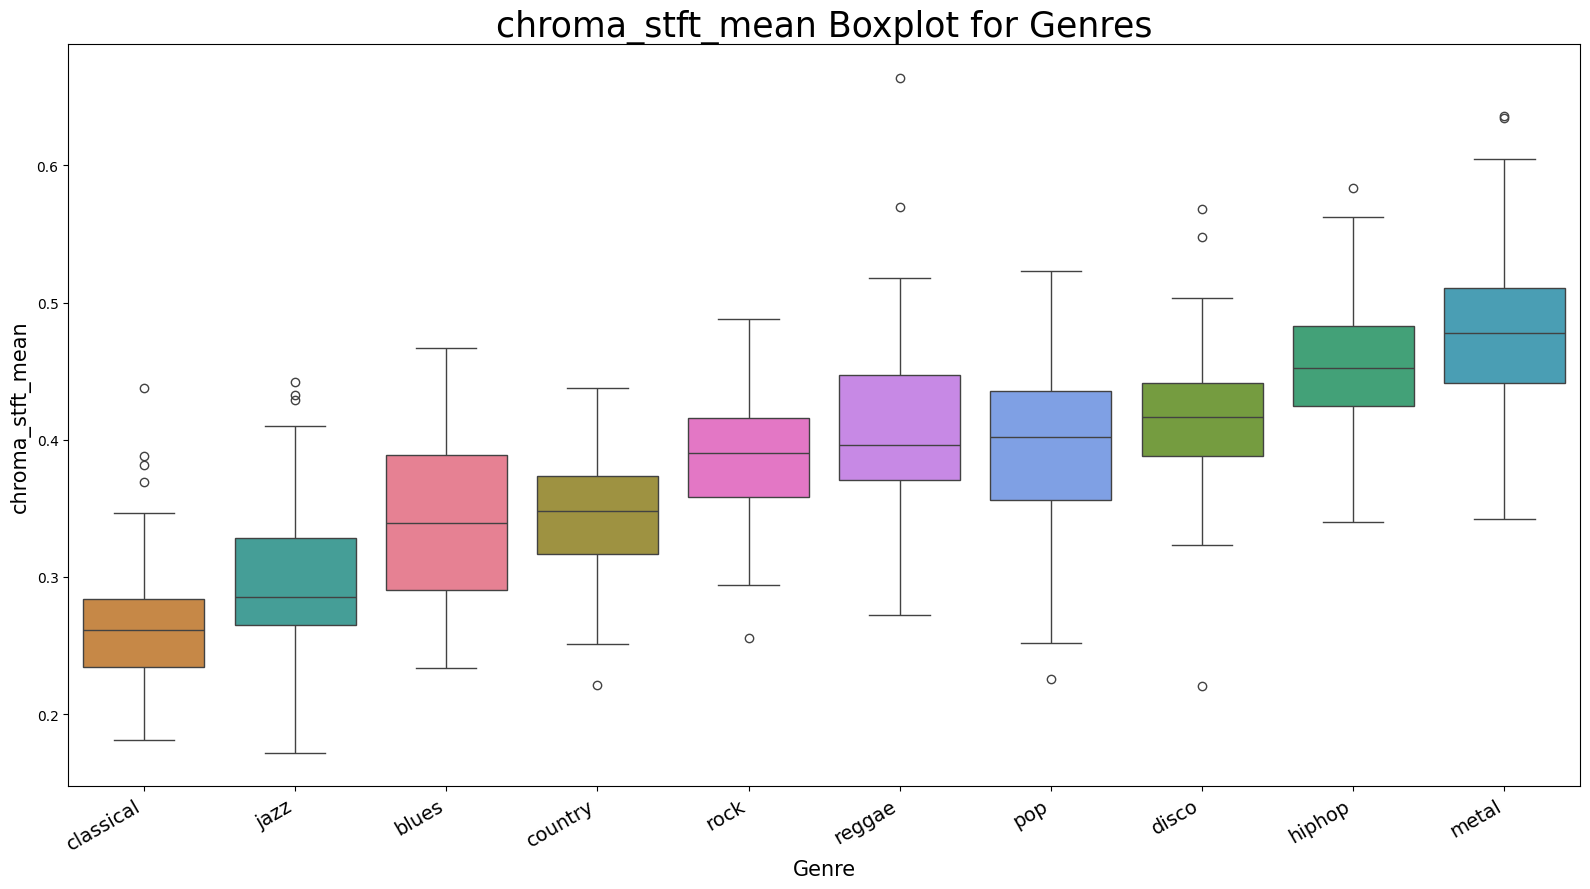

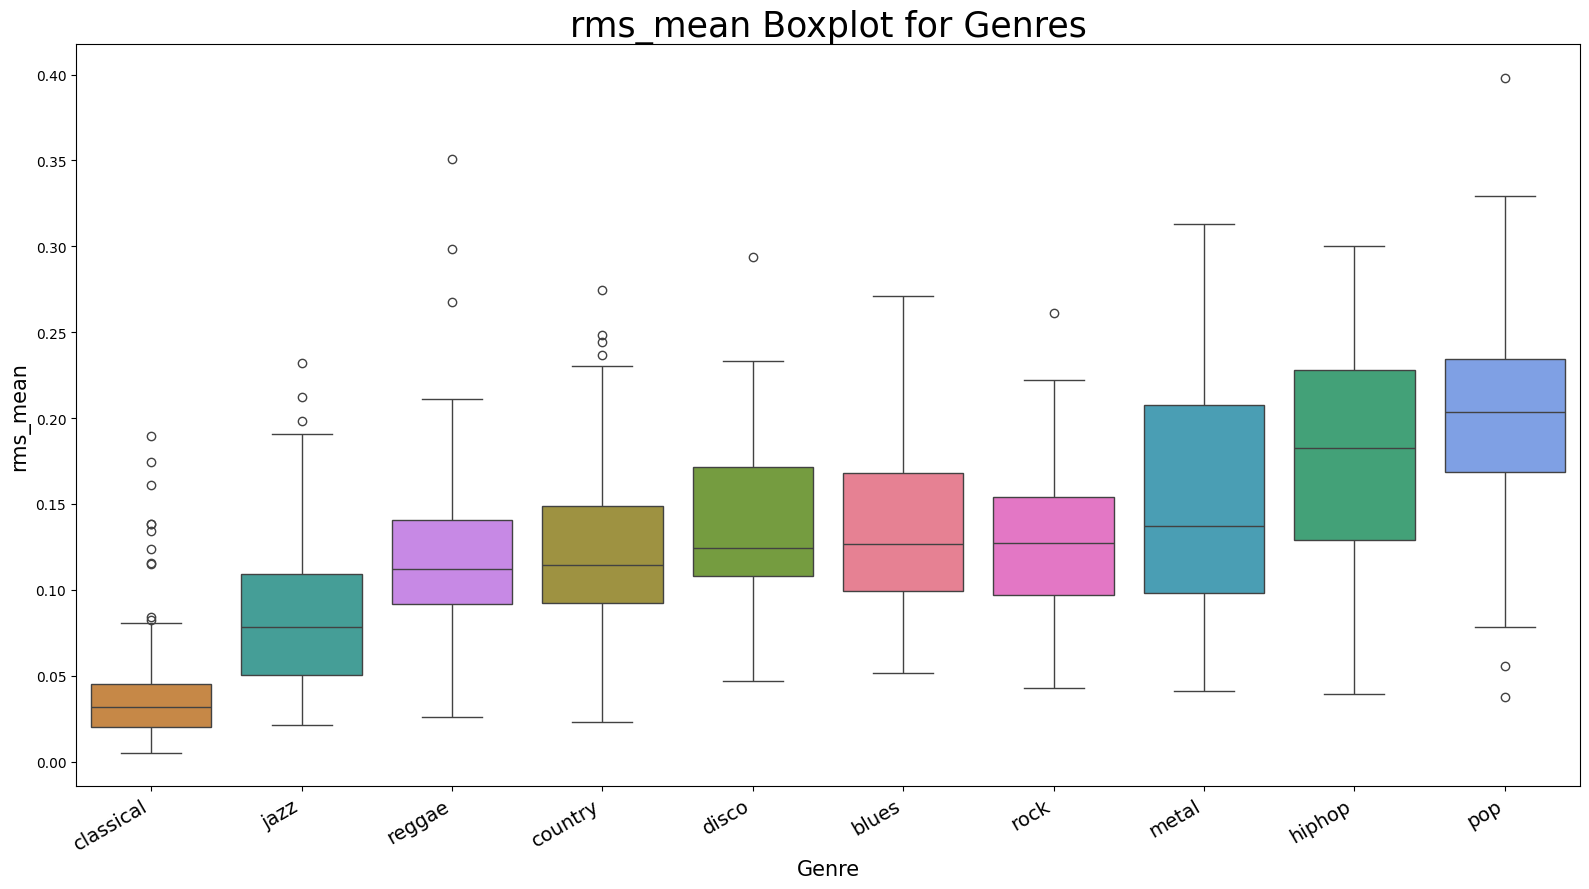

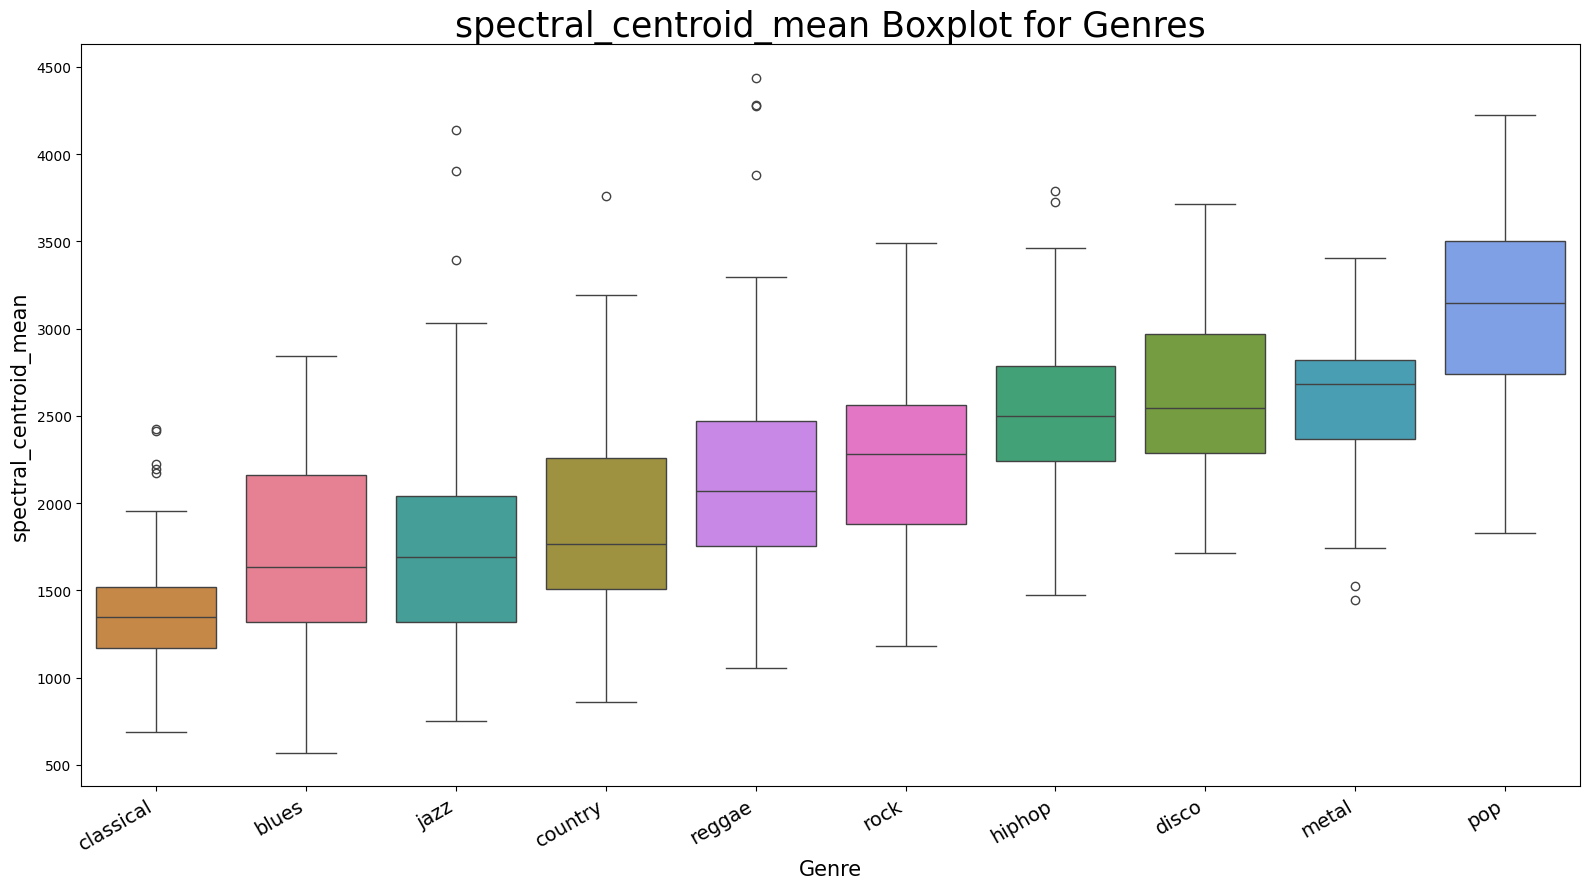

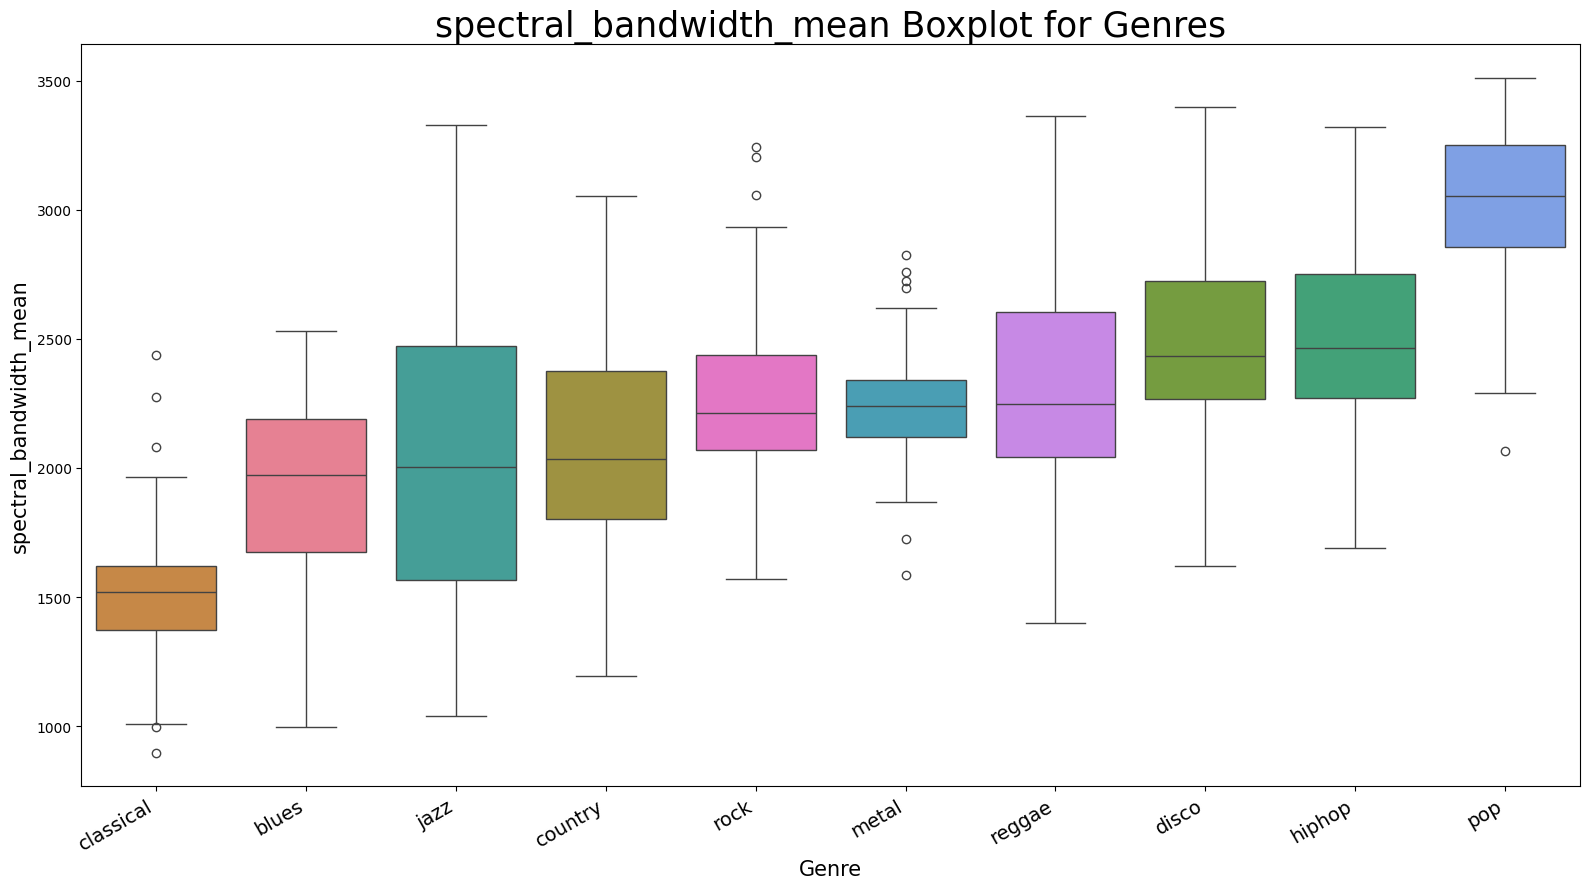

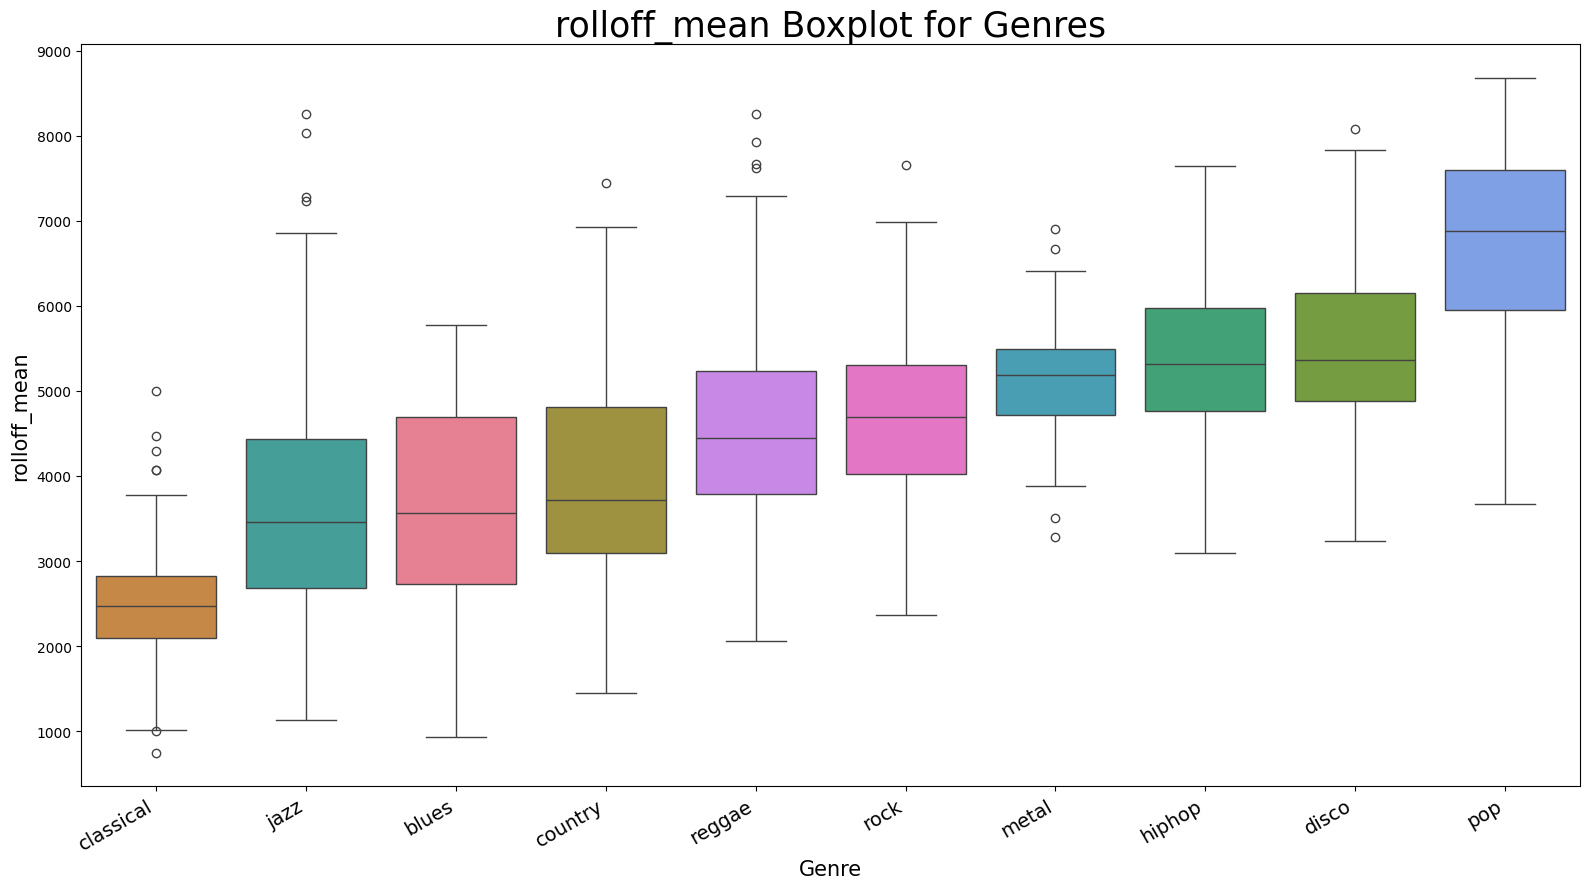

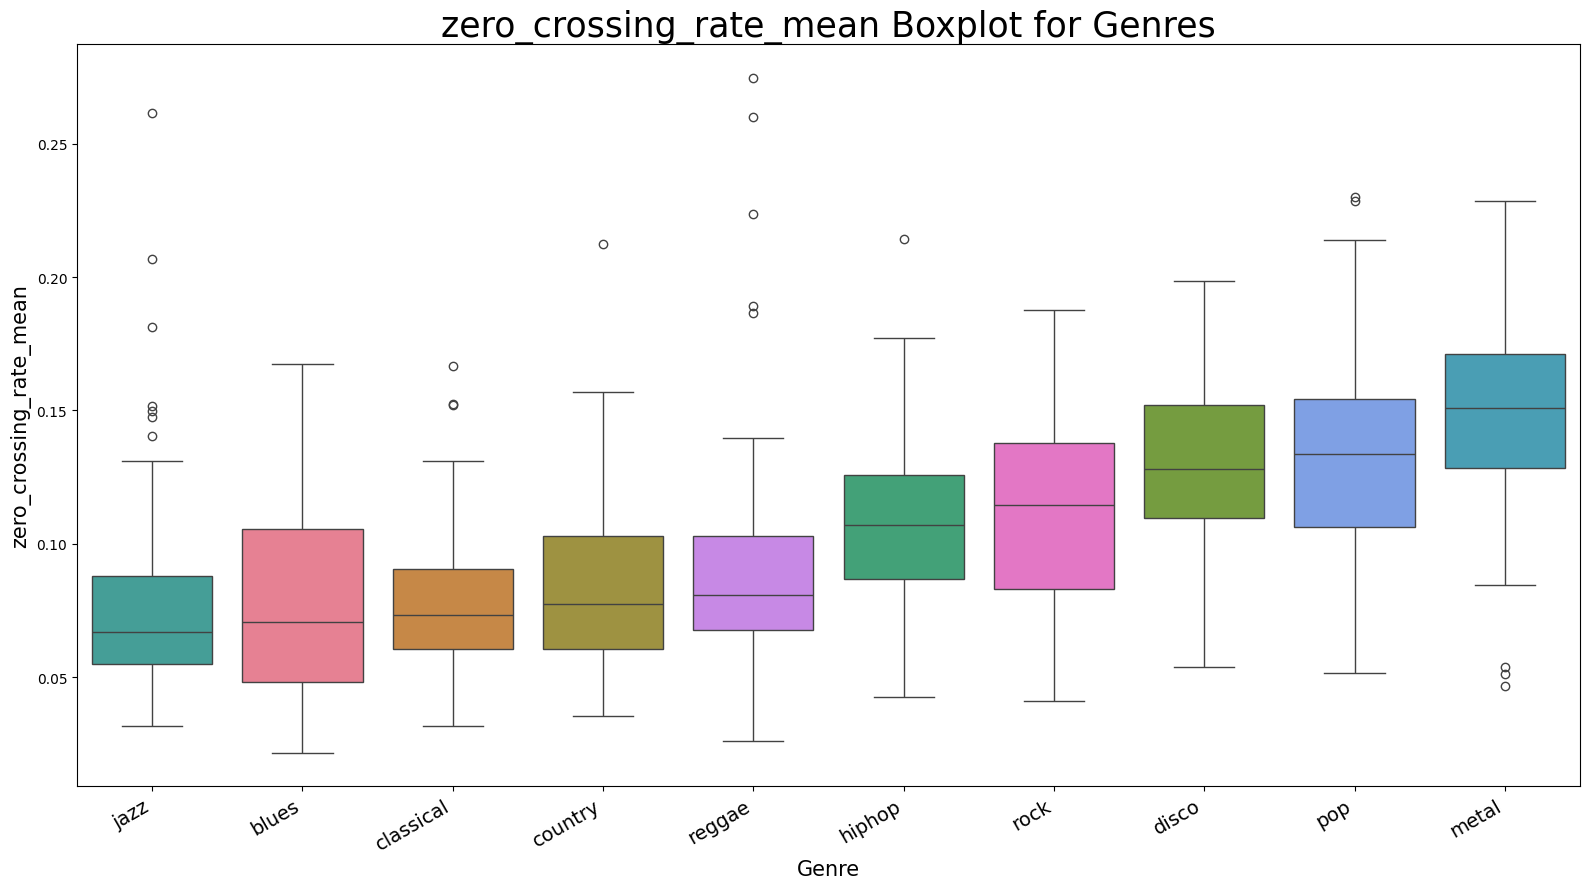

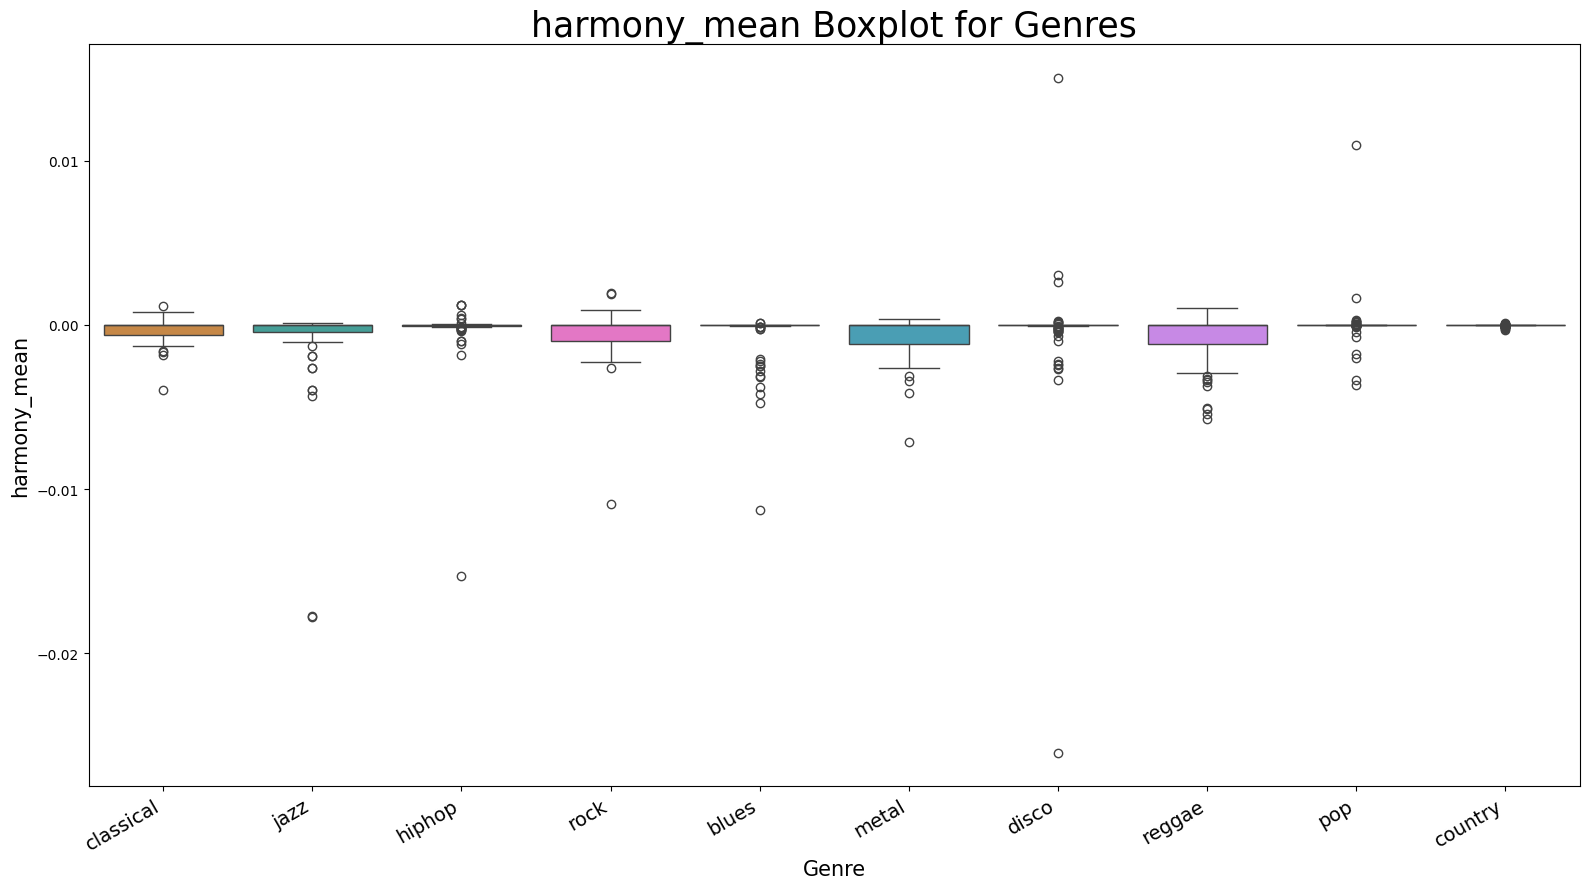

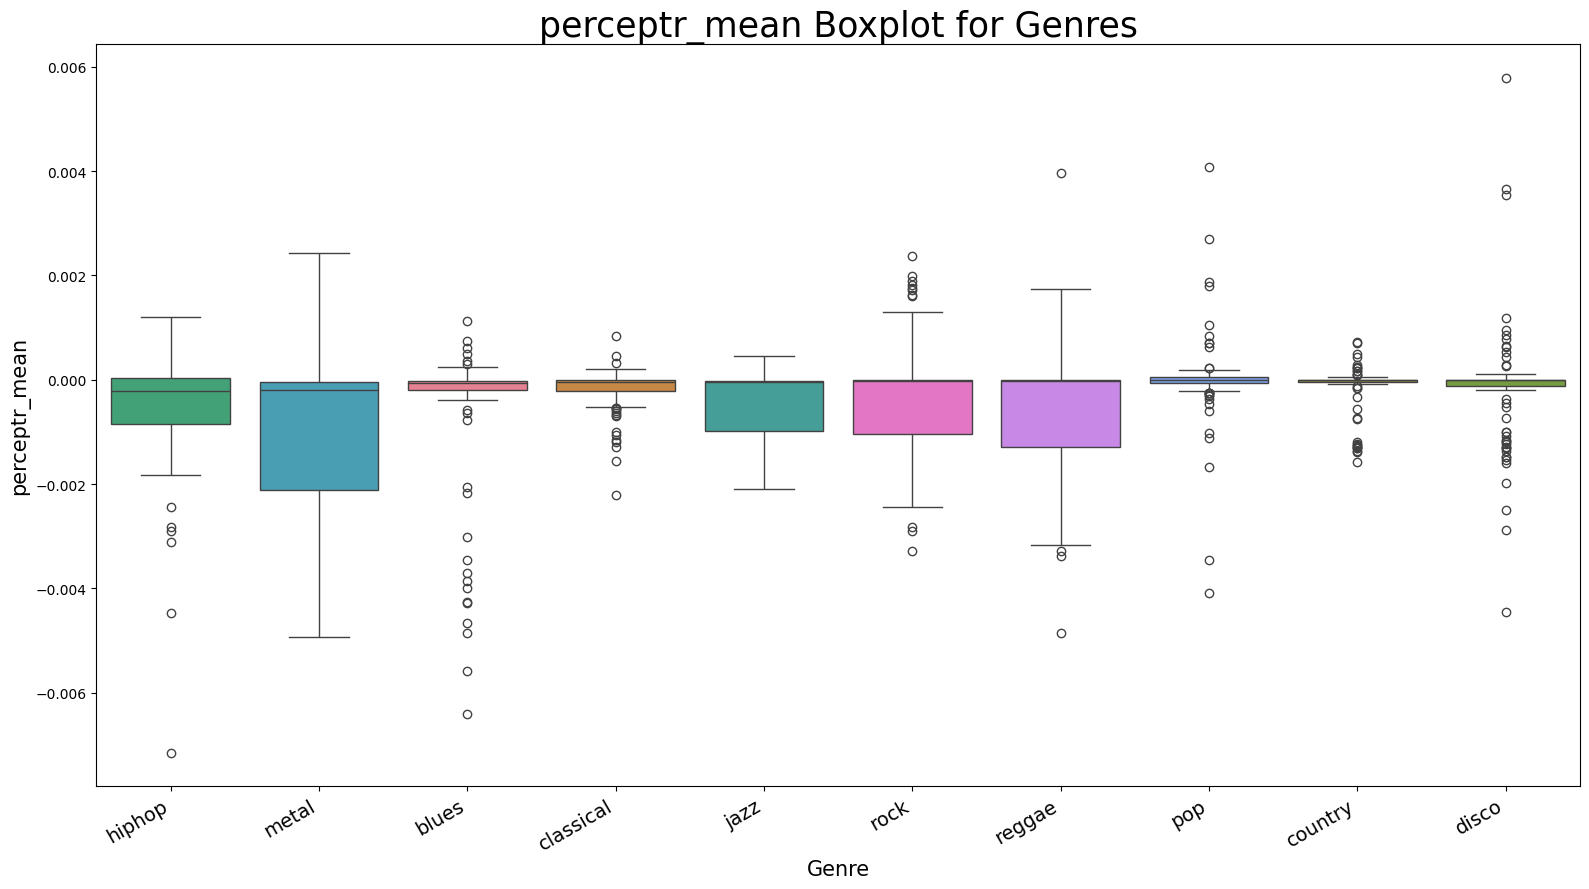

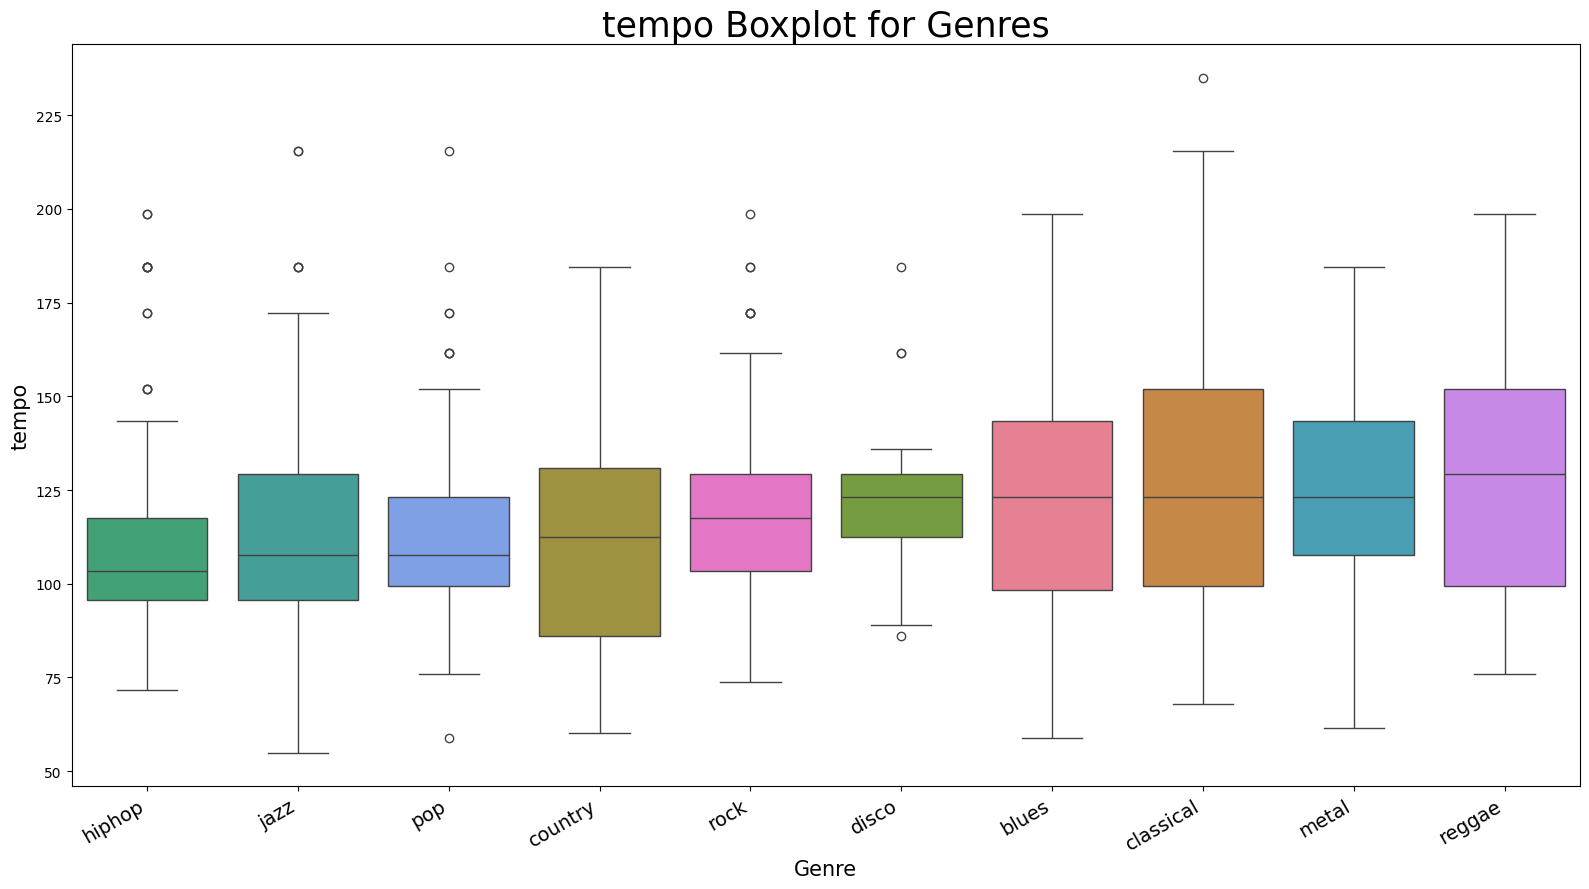

In [ ]:
features = ['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'rolloff_mean','zero_crossing_rate_mean',
       'harmony_mean', 'perceptr_mean','tempo',]
        # 리듬 기반의 feature를 추가하고 싶은 경우 여기에 추가하기

#같은 label은 같은 색깔
unique_labels = data['label'].unique()
palette = dict(zip(unique_labels, sns.color_palette('husl', len(unique_labels))))

for feature in features:
  #비슷한 미디언 기준으로 정렬
  order = (data.groupby('label')[feature]
          .median()
          .sort_values()
          .index)


  f, ax = plt.subplots(figsize=(16, 9))
  sns.boxplot(x="label", hue= "label", y=feature, data=data, order=order, palette=palette)
  plt.title(f'{feature} Boxplot for Genres', fontsize=25)
  plt.xticks(fontsize=14, rotation=30, ha='right')
  plt.yticks(fontsize=10)
  plt.xlabel("Genre", fontsize=15)
  plt.ylabel(feature, fontsize=15)
  plt.tight_layout()
  plt.savefig(f"{feature} Boxplot.jpg")

### t-SNE


In [ ]:
candidates = [
    # Energy
    'rms_mean', 'rms_var',
    # Spectral
    'spectral_centroid_mean', 'spectral_centroid_var',
    'spectral_bandwidth_mean', 'spectral_bandwidth_var',
    'rolloff_mean', 'rolloff_var',
    'zero_crossing_rate_mean', 'zero_crossing_rate_var',
    # Chroma/Harmony (있으면 사용)
    'chroma_stft_mean', 'chroma_stft_var',
    'harmony_mean', 'harmony_var',
    # MFCC 1~13 mean/var
    *[f'mfcc{i}_mean' for i in range(1, 14)],
    *[f'mfcc{i}_var'  for i in range(1, 14)],
] 
#여기에도 필요시 추가가능
# 아래 코드는 그대로
selected_features = [c for c in candidates if c in data.columns]


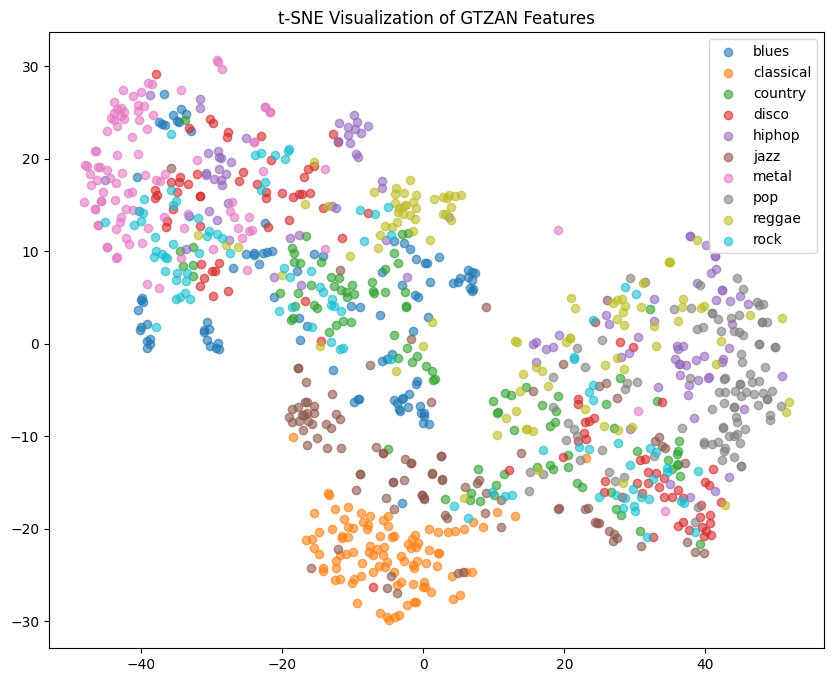

In [7]:
# 30 sec dataset 사용


# feature/label data
X = np.array(data[selected_features].values)
y = np.array(data['label'])

# Scale features before t-SNE
X_scaled = MinMaxScaler().fit_transform(X)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10,8))
for genre in np.unique(y):
    idx = y == genre
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=genre, alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization of GTZAN Features")
plt.show()

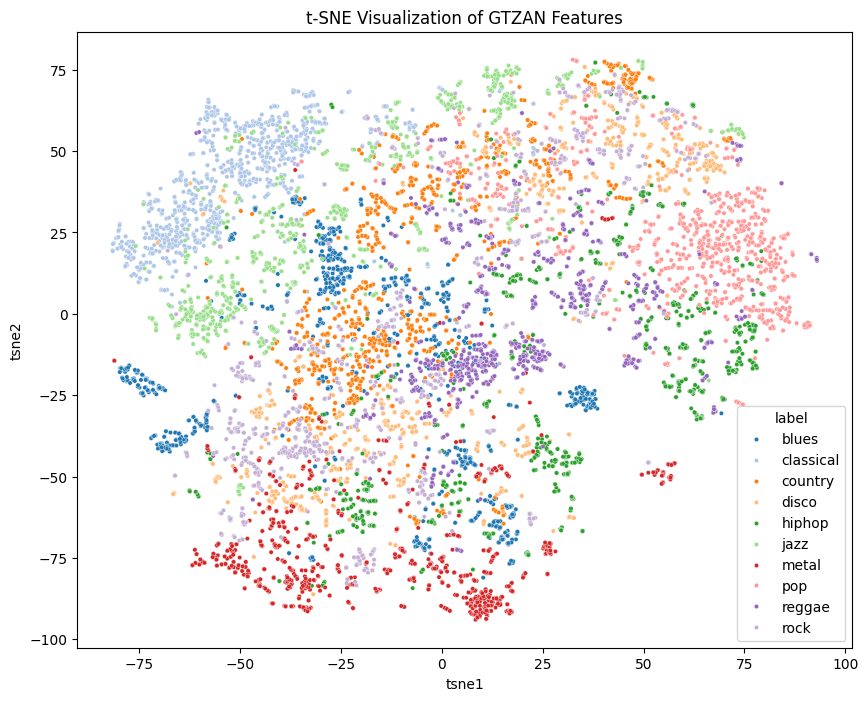

In [8]:
# 3 sec dataset 사용

data = pd.read_csv("./3_sec_addition.csv")

X = data[selected_features].values
labels = data["label"].values
X_scaled = MinMaxScaler().fit_transform(X)


# Run t-SNE on scaled features
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Save into  to reuse
data["tsne1"] = X_tsne[:, 0]
data["tsne2"] = X_tsne[:, 1]

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=data,
    x="tsne1", y="tsne2",
    hue="label",
    palette="tab20",
    s=10,
    legend="full"
)

plt.title("t-SNE Visualization of GTZAN Features")
plt.show()



## Feature Engineering

In [ ]:
# 3) 사용할 피처(실제 컬럼에 존재하는 것만 자동 선택)
candidates = [
    # Energy
    'rms_mean', 'rms_var',
    # Spectral
    'spectral_centroid_mean', 'spectral_centroid_var',
    'spectral_bandwidth_mean', 'spectral_bandwidth_var',
    'rolloff_mean', 'rolloff_var',
    'zero_crossing_rate_mean', 'zero_crossing_rate_var',
    # Chroma/Harmony (있으면 사용)
    'chroma_stft_mean', 'chroma_stft_var',
    'harmony_mean', 'harmony_var',
    # MFCC 1~13 mean/var
    *[f'mfcc{i}_mean' for i in range(1, 14)],
    *[f'mfcc{i}_var'  for i in range(1, 14)],
    'beat_strength', 'onset_rate',  #beat_strength, onset_rate가 없는 파일-> 이 부분 주석처리
    # 이 부분을 통해 추가 feature 인식
]


In [10]:
'''
candidates = [
 'rms_mean', 'rms_var',
 'spectral_centroid_mean', 'spectral_centroid_var',
 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', ..., 'mfcc14_mean',
 'mfcc1_var',  'mfcc2_var',  'mfcc3_var', ..., 'mfcc14_var',
]
형태로 flat하게 저장'''

''' mfcc가 20까지 존재하는데 14까지만 읽는 이유
1~13	    음색의 주요 정보 (포먼트, 음색, 악기 차이 등)	장르/음성 분류에 실제 유용
14~20 이후	고주파 성분, 잡음, 녹음 환경 차이	유용 정보 ↓, 노이즈 ↑
'''

' mfcc가 20까지 존재하는데 14까지만 읽는 이유\n1~13\t    음색의 주요 정보 (포먼트, 음색, 악기 차이 등)\t장르/음성 분류에 실제 유용\n14~20 이후\t고주파 성분, 잡음, 녹음 환경 차이\t유용 정보 ↓, 노이즈 ↑\n'

## Model Training

In [11]:
df = pd.read_csv("./3_sec_addition.csv")

In [12]:
# 2) filename 파싱 → 곡번호/장르/세그먼트 인덱스/곡키(song_key) 생성 후 반환
def parse_filename(name: str):
    # 예: "rock.00085.3.wav" → genre="rock", song_num=85, seg_idx=3
    m = re.match(r"([^.]+)\.(\d{5})\.(\d+)\.wav", name)
    if not m:
        return None, None, None
    genre, song_num_str, seg_idx_str = m.groups()
    return genre, int(song_num_str), int(seg_idx_str)

#dataframe = df.copy()

for dataframe in [df]: #for df in [train_df, test_df, df]:
    parsed = dataframe['filename'].apply(parse_filename)   # ex) "rock.00085.3.wav" → (("rock", 85, 3)) 이런 식으로 리턴
    dataframe['genre_from_name'] = [p[0] for p in parsed]  # ex) "rock"
    dataframe['song_num']        = [p[1] for p in parsed]  # ex) 85
    dataframe['seg_idx']         = [p[2] for p in parsed]  # ex) 3
    dataframe['song_key']        = dataframe.apply(lambda r: f"{r['genre_from_name']}.{r['song_num']:05d}", axis=1) # "rock.00085.3.wav" → "rock.00085"
    # 여기서 df['_'] 명령어는 '_'이라는 새로운 칼럼을 추가하는 명령어

In [13]:
#-----------

In [14]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['song_key']))

train_df = df.iloc[train_idx].copy()
test_df  = df.iloc[test_idx].copy()


In [15]:

# song-level table
song_df = df.groupby('song_key').agg(
    label=('label', 'first')
).reset_index()

# stratified split at song level
train_songs, test_songs = train_test_split(
    song_df['song_key'],
    test_size=0.2,
    random_state=42,
    stratify=song_df['label']
)

# build train/test segment-level dataframes
train_df = df[df['song_key'].isin(train_songs)].copy()
test_df  = df[df['song_key'].isin(test_songs)].copy()

In [16]:

scaler = MinMaxScaler()
train_df[selected_features] = scaler.fit_transform(train_df[selected_features])
test_df[selected_features]  = scaler.transform(test_df[selected_features])


### Clustering (finding sub-genres)

In [17]:
from sklearn.cluster import KMeans

N_CLUSTERS = 15
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=42)

train_segments = train_df[selected_features].values
segment_cluster_labels_train = kmeans.fit_predict(train_segments)

train_df["segment_cluster"] = segment_cluster_labels_train

test_segments = test_df[selected_features].values
test_df["segment_cluster"] = kmeans.predict(test_segments)



In [18]:
cluster_summaries = []

for cid in range(N_CLUSTERS):
    mask = train_df["segment_cluster"] == cid
    size = mask.sum()
    if size == 0:
        continue

    genre_counts = train_df.loc[mask, "label"].value_counts()
    ratios = (genre_counts / size).round(2)

    top_genres = [g for g, r in ratios.items() if r >= 0.1][:3]
    if not top_genres:
        top_genres = ["mixed"]

    cluster_name = f"{'_'.join(top_genres)}_{cid}"

    cluster_summaries.append({"cid": cid, "name": cluster_name})

for cluster in cluster_summaries:
  print(cluster)

# mapping name
name_map = {c["cid"]: c["name"] for c in cluster_summaries}


# ASSIGN names
train_df["global_subcluster"] = train_df["segment_cluster"].map(name_map)
test_df["global_subcluster"]  = test_df["segment_cluster"].map(name_map)


{'cid': 0, 'name': 'classical_jazz_0'}
{'cid': 1, 'name': 'metal_disco_1'}
{'cid': 2, 'name': 'pop_disco_2'}
{'cid': 3, 'name': 'reggae_hiphop_3'}
{'cid': 4, 'name': 'blues_country_jazz_4'}
{'cid': 5, 'name': 'disco_rock_pop_5'}
{'cid': 6, 'name': 'reggae_blues_hiphop_6'}
{'cid': 7, 'name': 'jazz_classical_country_7'}
{'cid': 8, 'name': 'blues_country_rock_8'}
{'cid': 9, 'name': 'jazz_classical_9'}
{'cid': 10, 'name': 'disco_rock_blues_10'}
{'cid': 11, 'name': 'country_jazz_pop_11'}
{'cid': 12, 'name': 'hiphop_pop_reggae_12'}
{'cid': 13, 'name': 'metal_blues_hiphop_13'}
{'cid': 14, 'name': 'pop_hiphop_reggae_14'}


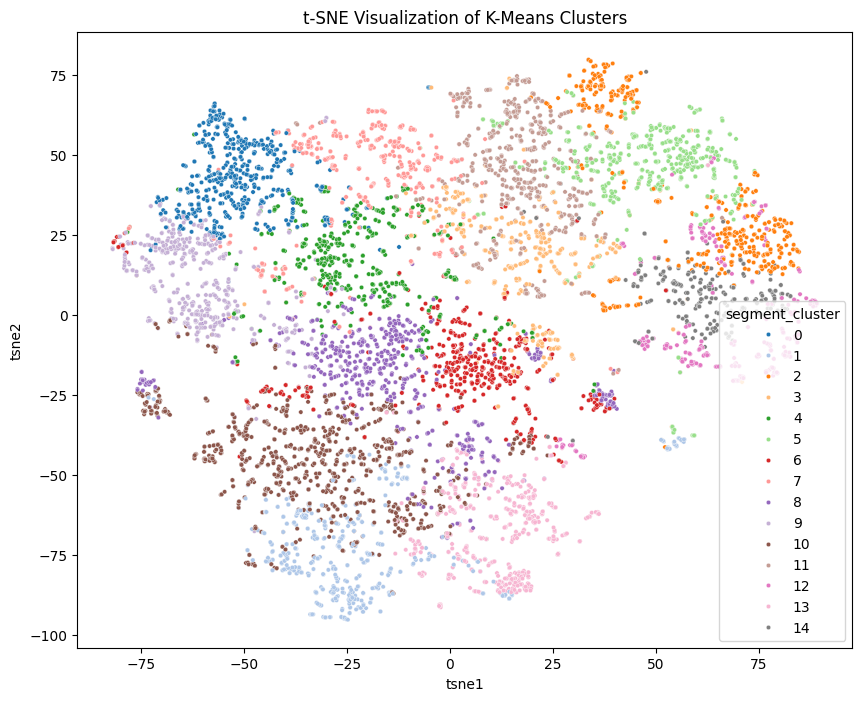

In [19]:


# Use only training data for visualization
X_train = train_df[selected_features].values
labels = train_df["global_subcluster"].values

# Run t-SNE on scaled features
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# Save into train_df to reuse
train_df["tsne1"] = X_tsne[:, 0]
train_df["tsne2"] = X_tsne[:, 1]

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=train_df,
    x="tsne1", y="tsne2",
    hue="segment_cluster",
    palette="tab20",
    s=10,
    legend="full"
)

plt.title("t-SNE Visualization of K-Means Clusters")
plt.show()


In [20]:

def print_subcluster_details(train_df, test_df, name_map):
    """
    Prints detailed summary for each discovered subcluster.
    """
    print("\n--- SUBCLUSTER DETAILS \n")

    # combine train + test
    full_df = pd.concat([train_df, test_df], ignore_index=True)

    # unique subclusters
    all_clusters = sorted(full_df["global_subcluster"].unique())

    for cname in all_clusters:
        print(f"\n--- Subcluster: {cname} ---")

        mask = full_df["global_subcluster"] == cname
        sub_df = full_df[mask]

        size = len(sub_df)
        print(f"Total segments: {size}")

        # genre distribution
        genre_counts = sub_df["label"].value_counts()
        total = genre_counts.sum()

        print("Genre distribution:")
        for genre, count in genre_counts.items():
            pct = count / total * 100
            print(f"  {genre:10s} : {count:5d}  ({pct:5.1f}%)")


In [21]:
print_subcluster_details(train_df, test_df, name_map)


--- SUBCLUSTER DETAILS 


--- Subcluster: blues_country_jazz_4 ---
Total segments: 658
Genre distribution:
  blues      :   271  ( 41.2%)
  country    :   158  ( 24.0%)
  jazz       :   134  ( 20.4%)
  reggae     :    58  (  8.8%)
  rock       :    22  (  3.3%)
  classical  :    10  (  1.5%)
  hiphop     :     4  (  0.6%)
  pop        :     1  (  0.2%)

--- Subcluster: blues_country_rock_8 ---
Total segments: 781
Genre distribution:
  country    :   228  ( 29.2%)
  blues      :   208  ( 26.6%)
  rock       :   130  ( 16.6%)
  disco      :    62  (  7.9%)
  reggae     :    55  (  7.0%)
  hiphop     :    43  (  5.5%)
  jazz       :    29  (  3.7%)
  metal      :    25  (  3.2%)
  classical  :     1  (  0.1%)

--- Subcluster: classical_jazz_0 ---
Total segments: 685
Genre distribution:
  classical  :   536  ( 78.2%)
  jazz       :   107  ( 15.6%)
  country    :    18  (  2.6%)
  blues      :    14  (  2.0%)
  rock       :     5  (  0.7%)
  hiphop     :     2  (  0.3%)
  metal      :     

In [22]:
X_train = train_df[selected_features]
y_train = train_df["global_subcluster"]

X_test  = test_df[selected_features]
y_test  = test_df["global_subcluster"]


In [23]:
#------

Best k = 19, Accuracy = 0.8009


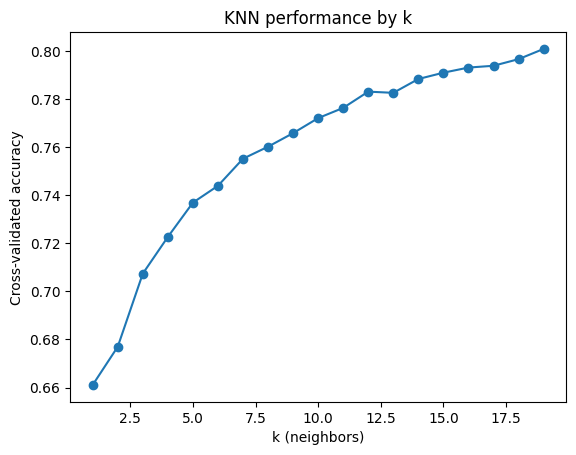

In [24]:
# 4-1) n_neighbors 최적값 찾기

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

X = X_train
y = y_train
# k = 1 에서 k = 20 까지 확인
k_values = range(1, 20)
cv_scores = []

# cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(
        knn,
        X,
        y,
        cv=10,
        #groups=groups_train,
        scoring='accuracy'
    )
    cv_scores.append(scores.mean())

# best k 찾기
best_k = k_values[np.argmax(cv_scores)]
print(f"Best k = {best_k}, Accuracy = {max(cv_scores):.4f}")

plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (neighbors)')
plt.ylabel('Cross-validated accuracy')
plt.title('KNN performance by k')
plt.show()

In [25]:
# 5-1) KNN 학습
knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19, weights='distance')

In [26]:
# 5-2) Decision Tree

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train) #X_train_Scaled

DecisionTreeClassifier()

In [27]:
# 5-3) Random Forest
rforest = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=0)

In [28]:
# 5-4) Ada Boost
ada = AdaBoostClassifier(n_estimators=500)
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500)

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [30]:
# 5-5) XgBoost


xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',   # predict class index directly
    num_class=10,
    eval_metric='mlogloss',
    tree_method='hist',          # faster on CPU
    random_state=42
)

xgb.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=10, ...)

In [31]:
importance = xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

importance_df.head(20)

,feature,importance
6,rolloff_mean,13.542172
0,rms_mean,7.185497
2,spectral_centroid_mean,6.927954
14,mfcc1_mean,5.898686
3,spectral_centroid_var,5.312036
4,spectral_bandwidth_mean,5.075352
21,mfcc8_mean,4.965868
11,chroma_stft_var,4.697144
13,harmony_var,4.339227
18,mfcc5_mean,4.176783


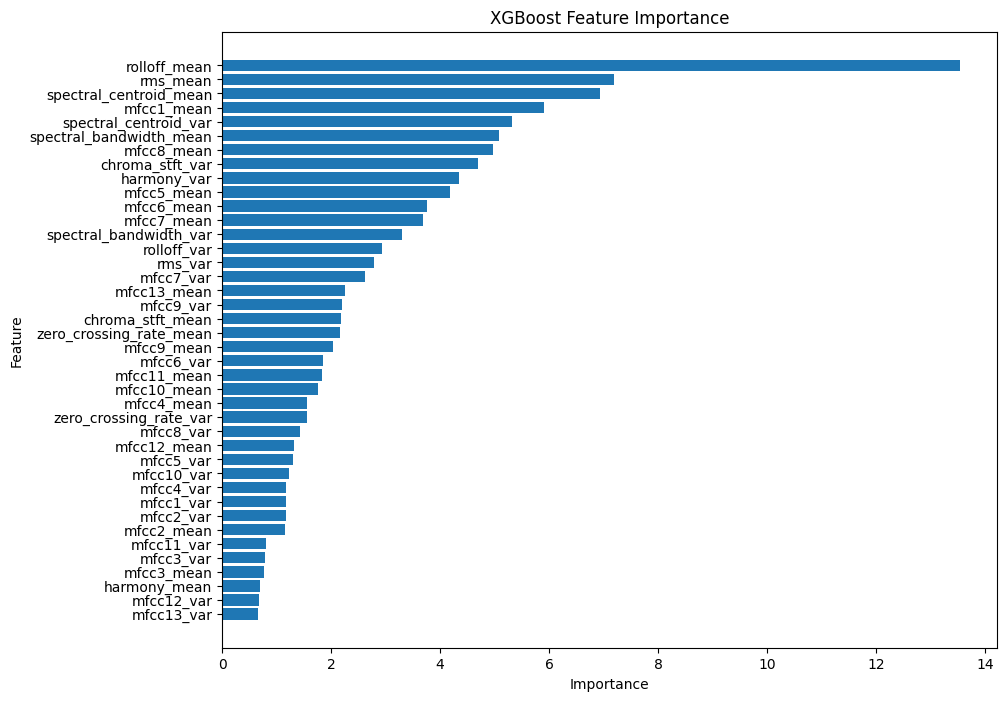

In [32]:
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Model evaluation

In [33]:
test_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc20_var,label,onset_rate,beat_strength,genre_from_name,song_num,seg_idx,song_key,segment_cluster,global_subcluster
10,blues.00001.0.wav,66149,0.526533,0.674205,0.261792,0.118810,0.180037,0.084639,0.450642,0.158344,...,21.973501,blues,3.000000,1.620372,blues,1,0,blues.00001,6,reggae_blues_hiphop_6
11,blues.00001.1.wav,66149,0.425087,0.683654,0.266489,0.045810,0.232408,0.044637,0.504550,0.097810,...,34.120010,blues,4.000000,1.419626,blues,1,1,blues.00001,6,reggae_blues_hiphop_6
12,blues.00001.2.wav,66149,0.411912,0.583968,0.275463,0.042466,0.186665,0.032002,0.319678,0.089243,...,96.283142,blues,3.666667,1.413029,blues,1,2,blues.00001,4,blues_country_jazz_4
13,blues.00001.3.wav,66149,0.398774,0.722947,0.239761,0.080969,0.224765,0.134783,0.445935,0.288925,...,37.799568,blues,2.666667,1.419647,blues,1,3,blues.00001,6,reggae_blues_hiphop_6
14,blues.00001.4.wav,66149,0.429579,0.806441,0.248598,0.067567,0.280602,0.118502,0.523343,0.123700,...,31.121618,blues,3.333333,1.504998,blues,1,4,blues.00001,6,reggae_blues_hiphop_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,rock.00095.5.wav,66149,0.518459,0.544975,0.223196,0.013684,0.361193,0.051869,0.529439,0.048969,...,16.310219,rock,4.666667,1.308055,rock,95,5,rock.00095,10,disco_rock_blues_10
9946,rock.00095.6.wav,66149,0.489265,0.509379,0.272293,0.005533,0.357824,0.046055,0.507372,0.059646,...,35.840061,rock,4.333333,1.160095,rock,95,6,rock.00095,10,disco_rock_blues_10
9947,rock.00095.7.wav,66149,0.513940,0.452015,0.267172,0.006003,0.359706,0.058139,0.514254,0.074209,...,12.396221,rock,4.000000,1.141932,rock,95,7,rock.00095,10,disco_rock_blues_10
9948,rock.00095.8.wav,66149,0.482745,0.531998,0.258909,0.005516,0.384319,0.062207,0.542453,0.080028,...,43.324844,rock,4.333333,1.148454,rock,95,8,rock.00095,10,disco_rock_blues_10


In [34]:
# show how each subcluster aligns with original genre
# answers what hidden sub-genre structure exists inside GTZAN
# meausres how well do these sub-genres align with GTZAN’s official labels
# shows which genres are acoustically clean or ambiguous

def calculate_accuracy_by_song(model, model_name, test_df):

  # 6) 세그먼트 단위 예측 → 곡 단위로 다수결 집계

  if model == xgb:
    y_pred_enc = model.predict(X_test)
    test_pred_segment = le.inverse_transform(y_pred_enc)
  else:
    test_pred_segment = model.predict(X_test)

  test_df = test_df.copy()
  #test_df =  dataframe.loc[X_test.index].copy()
  test_df['pred_segment'] = test_pred_segment



  song_preds = {}
  song_trues = {}
  for song_key, group in test_df.groupby('song_key'):
      # (1) 예측 다수결
      pred_counts = Counter(group['pred_segment'])
      maj_pred = pred_counts.most_common(1)[0][0]
      song_preds[song_key] = maj_pred
      # (2) 정답 라벨 (대부분 동일해야 정상, 혹시 다르면 최빈값 사용)
      true_counts = Counter(group['global_subcluster']) #label/global_subcluster
      maj_true = true_counts.most_common(1)[0][0]
      song_trues[song_key] = maj_true

    # 7) 곡 단위 평가 (장르당 20곡, 총 200곡 기대)
  song_eval = pd.DataFrame({
      'song_key': list(song_preds.keys()),
      'pred':     [song_preds[k] for k in song_preds.keys()],
      'true':     [song_trues[k] for k in song_preds.keys()],
  })
  song_eval['genre'] = song_eval['song_key'].str.split('.').str[0]


  total_songs = len(song_eval)  # 정상이라면 200
  num_correct = (song_eval['pred'] == song_eval['true']).sum()
  accuracy = num_correct / total_songs if total_songs else 0.0


  print(f"===== {model_name} 곡-단위 평가 결과 =====")
  print(f"총 테스트 곡 수: {total_songs} (기대: 200)")
  print(f"정답 맞춘 곡 수: {num_correct} / {total_songs}  (Accuracy: {accuracy:.4f})\n")

  # 장르별 정확도(각 20곡인지 확인)
  song_eval['correct'] = (song_eval['pred'] == song_eval['true']).astype(int)

  per_genre = (
      song_eval.groupby('genre', as_index=False)
              .agg(num_songs=('song_key', 'size'),
                    num_correct=('correct', 'sum'))
  )

  per_genre['accuracy'] = per_genre['num_correct'] / per_genre['num_songs']

  print("장르별 곡-단위 정확도:")
  print(per_genre.to_string(index=False))

In [35]:
#평가 지표 추가 도입

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_segment_metrics(model, model_name, X_test, y_test, is_xgb=False):
    """
    이미 fit 되어 있는 model을 받아서
    세그먼트 단위 Accuracy / F1 / Confusion Matrix를 출력하는 함수
    """
    if is_xgb:
        # XGBoost는 y를 인코딩해서 학습했으니까, 예측도 inverse_transform 해줘야 함
        y_pred_enc = model.predict(X_test)
        y_pred = le.inverse_transform(y_pred_enc)
        y_true = y_test          # 원래 문자열 라벨
    else:
        y_pred = model.predict(X_test)
        y_true = y_test

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    print(f"\n===== [Segment-level] {model_name} =====")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Macro F1     : {f1_macro:.4f}")
    print(f"Weighted F1  : {f1_weighted:.4f}")
    print("\n[Classification report]")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    if hasattr(y_true, "unique"):
        labels = sorted(y_true.unique())
    else:
        labels = np.unique(y_true)

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                xticklabels=labels,
                yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name} (segment)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc, f1_macro, f1_weighted



===== [Segment-level] KNN =====
Accuracy     : 0.8530
Macro F1     : 0.8432
Weighted F1  : 0.8524

[Classification report]
                          precision    recall  f1-score   support

    blues_country_jazz_4       0.96      0.79      0.87       186
    blues_country_rock_8       0.80      0.82      0.81       130
        classical_jazz_0       0.90      0.90      0.90       145
     country_jazz_pop_11       0.83      0.92      0.87       156
     disco_rock_blues_10       0.84      0.89      0.86       189
        disco_rock_pop_5       0.81      0.86      0.84       107
    hiphop_pop_reggae_12       0.70      0.67      0.68        79
        jazz_classical_9       0.87      0.87      0.87       136
jazz_classical_country_7       0.76      0.87      0.81        62
   metal_blues_hiphop_13       0.84      0.91      0.87       183
           metal_disco_1       0.91      0.84      0.87       128
             pop_disco_2       0.83      0.95      0.89       148
    pop_hiphop_re

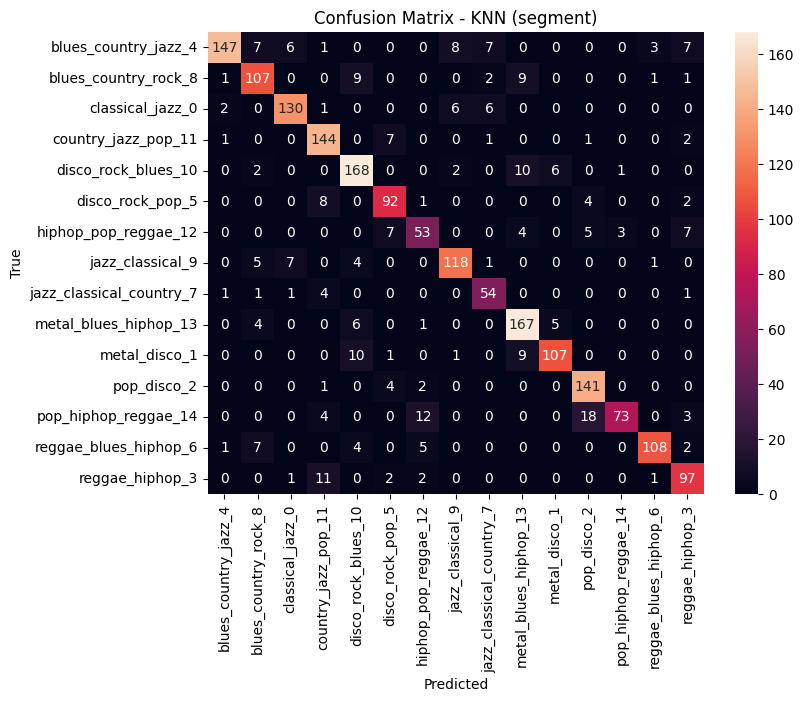


===== [Segment-level] Decision Tree =====
Accuracy     : 0.7065
Macro F1     : 0.6908
Weighted F1  : 0.7066

[Classification report]
                          precision    recall  f1-score   support

    blues_country_jazz_4       0.78      0.63      0.70       186
    blues_country_rock_8       0.56      0.65      0.60       130
        classical_jazz_0       0.78      0.89      0.83       145
     country_jazz_pop_11       0.71      0.65      0.68       156
     disco_rock_blues_10       0.75      0.78      0.76       189
        disco_rock_pop_5       0.61      0.71      0.66       107
    hiphop_pop_reggae_12       0.62      0.67      0.65        79
        jazz_classical_9       0.71      0.75      0.73       136
jazz_classical_country_7       0.49      0.45      0.47        62
   metal_blues_hiphop_13       0.81      0.73      0.77       183
           metal_disco_1       0.83      0.78      0.80       128
             pop_disco_2       0.76      0.78      0.77       148
    pop

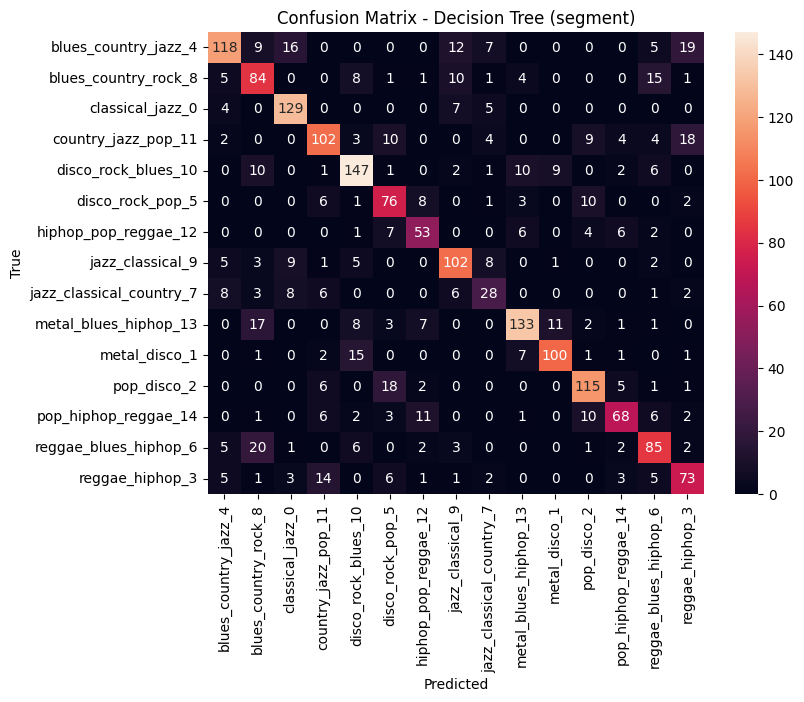


===== [Segment-level] Random Forest =====
Accuracy     : 0.8450
Macro F1     : 0.8397
Weighted F1  : 0.8456

[Classification report]
                          precision    recall  f1-score   support

    blues_country_jazz_4       0.91      0.82      0.86       186
    blues_country_rock_8       0.69      0.88      0.77       130
        classical_jazz_0       0.88      0.95      0.92       145
     country_jazz_pop_11       0.77      0.90      0.83       156
     disco_rock_blues_10       0.81      0.89      0.85       189
        disco_rock_pop_5       0.85      0.87      0.86       107
    hiphop_pop_reggae_12       0.80      0.75      0.77        79
        jazz_classical_9       0.91      0.87      0.89       136
jazz_classical_country_7       0.74      0.84      0.79        62
   metal_blues_hiphop_13       0.87      0.83      0.85       183
           metal_disco_1       0.92      0.78      0.84       128
             pop_disco_2       0.89      0.89      0.89       148
    pop

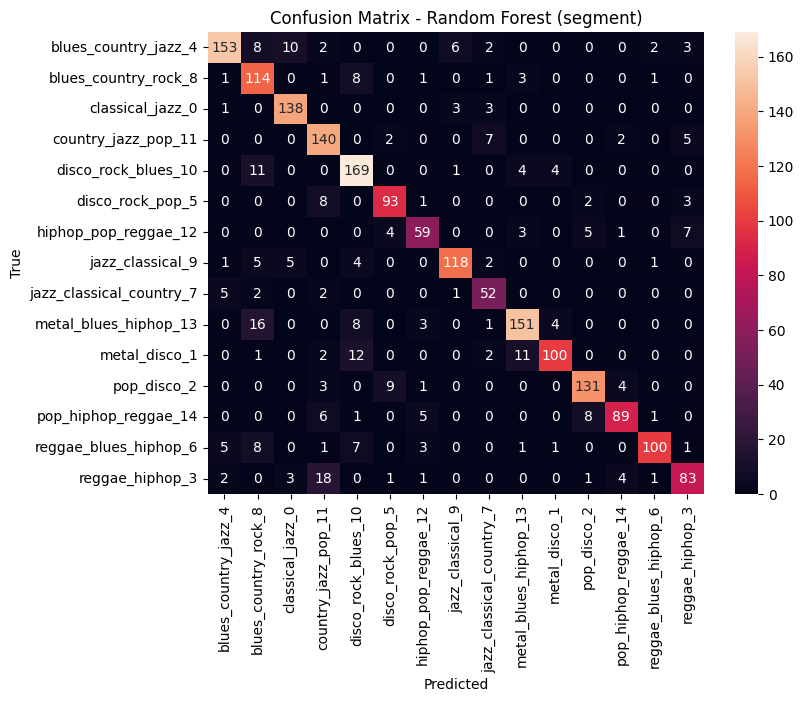


===== [Segment-level] AdaBoost =====
Accuracy     : 0.6145
Macro F1     : 0.5845
Weighted F1  : 0.5906

[Classification report]
                          precision    recall  f1-score   support

    blues_country_jazz_4       0.79      0.73      0.76       186
    blues_country_rock_8       0.50      0.86      0.63       130
        classical_jazz_0       0.91      0.42      0.58       145
     country_jazz_pop_11       0.55      0.83      0.66       156
     disco_rock_blues_10       0.63      0.88      0.73       189
        disco_rock_pop_5       0.39      0.90      0.54       107
    hiphop_pop_reggae_12       0.76      0.41      0.53        79
        jazz_classical_9       0.69      0.71      0.70       136
jazz_classical_country_7       0.42      0.85      0.56        62
   metal_blues_hiphop_13       0.75      0.42      0.54       183
           metal_disco_1       0.67      0.36      0.47       128
             pop_disco_2       0.19      0.02      0.04       148
    pop_hiph

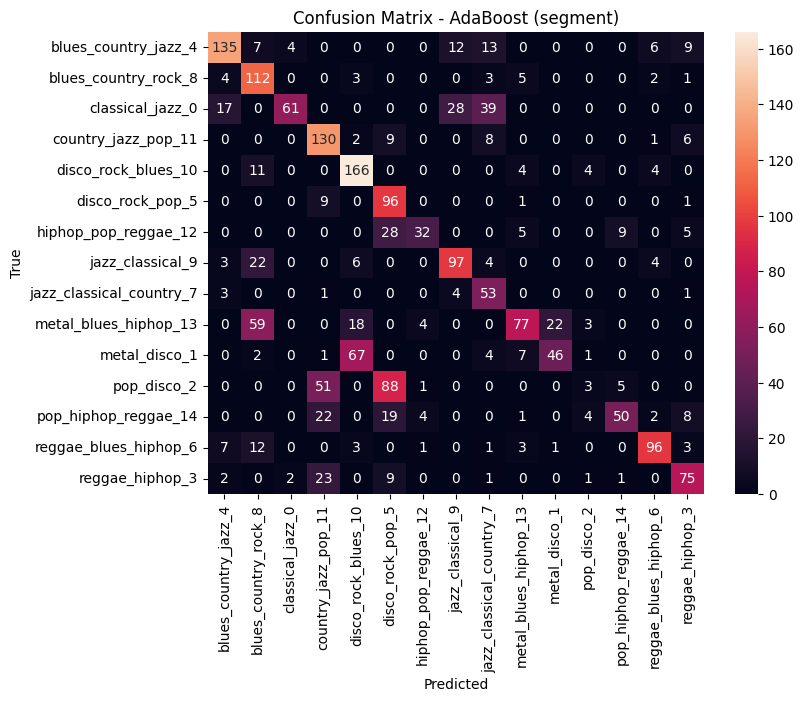


===== [Segment-level] XGBoost =====
Accuracy     : 0.8970
Macro F1     : 0.8926
Weighted F1  : 0.8974

[Classification report]
                          precision    recall  f1-score   support

    blues_country_jazz_4       0.95      0.88      0.91       186
    blues_country_rock_8       0.81      0.89      0.85       130
        classical_jazz_0       0.93      0.94      0.94       145
     country_jazz_pop_11       0.87      0.92      0.90       156
     disco_rock_blues_10       0.91      0.91      0.91       189
        disco_rock_pop_5       0.90      0.89      0.90       107
    hiphop_pop_reggae_12       0.86      0.82      0.84        79
        jazz_classical_9       0.93      0.91      0.92       136
jazz_classical_country_7       0.86      0.87      0.86        62
   metal_blues_hiphop_13       0.92      0.89      0.91       183
           metal_disco_1       0.95      0.91      0.93       128
             pop_disco_2       0.91      0.93      0.92       148
    pop_hipho

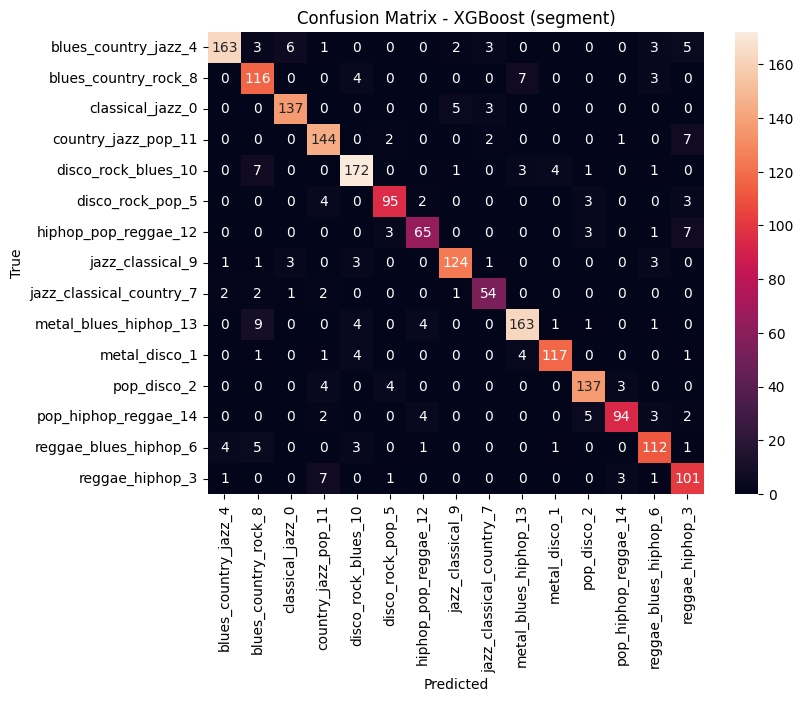

,Model,Accuracy,Macro_F1,Weighted_F1
0,KNN,0.8530,0.843185,0.852399
1,Decision Tree,0.7065,0.690781,0.706556
2,Random Forest,0.8450,0.839672,0.845583
3,AdaBoost,0.6145,0.584505,0.590645
4,XGBoost,0.8970,0.892590,0.897424


In [36]:

# ---- 세그먼트 단위 성능 비교 ----
segment_results = []

segment_results.append(("KNN",) + evaluate_segment_metrics(knn, "KNN", X_test, y_test))
segment_results.append(("Decision Tree",) + evaluate_segment_metrics(tree, "Decision Tree", X_test, y_test))
segment_results.append(("Random Forest",) + evaluate_segment_metrics(rforest, "Random Forest", X_test, y_test))
segment_results.append(("AdaBoost",) + evaluate_segment_metrics(ada, "AdaBoost", X_test, y_test))
segment_results.append(("XGBoost",) + evaluate_segment_metrics(xgb, "XGBoost", X_test, y_test, is_xgb=True))

segment_df = pd.DataFrame(segment_results, columns=["Model", "Accuracy", "Macro_F1", "Weighted_F1"])
display(segment_df)

# calculate_accuracy_by_song(knn, "KNN", test_df)
# calculate_accuracy_by_song(tree, "Decision Tree", test_df)
# calculate_accuracy_by_song(rforest, "RandomForest", test_df)
# calculate_accuracy_by_song(ada, "AdaBoost", test_df)
# calculate_accuracy_by_song(xgb, "XGBoost", test_df)

In [37]:

'''
평가:
정확도가 낮은 이유 & 바로 적용할 개선 방법

1. 왜 낮게 나오는가? (데이터/모델 관점에서)
    KNN은 아주 단순한 거리 기반 -> 스케일은 표준화로 보정했지만, 거리(metric)·k·가중치(weights) 선택에 따라 성능 편차가 크다.
    현재 k=5, metric=euclidean, weights=distance는 “무난한 출발점”일 뿐, 최적은 아님. (가장 가까운 5개를 보고 다수결로 결정)

2. 피처-장르 적합도 문제
    CSV에 템포/비트 관련 피처가 거의 없음(e.g., tempo, beat strength).
    힙합/컨트리처럼 리듬/비트 차별성이 핵심인 장르는 MFCC/스펙트럴만으로 구분이 어렵다.
    그래서 classical·pop·metal은 잘 맞고, hiphop·country는 낮게 나오는 경향이 있다(지금 결과와 동일한 패턴).


3. 세그먼트(3초) 학습 → 곡 단위 평가의 분포 불일치
    학습은 세그먼트, 평가는 곡 단위 다수결.
    세그먼트 노이즈가 많은 장르는 다수결로도 안정화가 덜 될 수 있다.


4. k/metric/weights/피처 조합 미튜닝
    간단한 튜닝만 해도 체감 향상되는 경우가 많다.
    특히 cosine/Manhattan 거리, k 증감, MFCC만/스펙트럴만 같은 피처 번들 실험이 효과적.

'''


'''
v1.2 추가
1. KNN -> 낮게 나옴: cross validation 을 사용해 best_k 찾은 후
  model training. accuracy: 0.5 (100/200) -> 0.525 (105/200).
  유의미한 변화 x 다른 모델 사용 필요

2. EDA 추가 -> Boxplot and t-SNE

3. MinmaxScaler 사용 했으나 accuracy 0.46 로 떨어짐

4. 다른 classifier - Decision Tree, Random Forest, AdaBoost 사용,
모두 KNN 보다 성능 떨어짐

** 추가할 부분:
- 모델이 segment 단위로 학습되었기 때문에 한 곡 단위 보다는 각 장르별 segment accuracy를 보는 것도 평가에 중요
- 현재는 간단한 accuracy score만 사용했으나
  다른 accuracy 지표 추가 필요 예) confusion matrix, classification report(precision, recall, f1)

'''

'\nv1.2 추가\n1. KNN -> 낮게 나옴: cross validation 을 사용해 best_k 찾은 후\n  model training. accuracy: 0.5 (100/200) -> 0.525 (105/200).\n  유의미한 변화 x 다른 모델 사용 필요\n\n2. EDA 추가 -> Boxplot and t-SNE\n\n3. MinmaxScaler 사용 했으나 accuracy 0.46 로 떨어짐\n\n4. 다른 classifier - Decision Tree, Random Forest, AdaBoost 사용,\n모두 KNN 보다 성능 떨어짐\n\n** 추가할 부분:\n- 모델이 segment 단위로 학습되었기 때문에 한 곡 단위 보다는 각 장르별 segment accuracy를 보는 것도 평가에 중요\n- 현재는 간단한 accuracy score만 사용했으나\n  다른 accuracy 지표 추가 필요 예) confusion matrix, classification report(precision, recall, f1)\n\n'